In [39]:
import os
import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.utils import get_modflow
from copy import deepcopy

In [ ]:
# Define paths and filenames
modflow_path = "../modflow"                  # Directory to MODFLOW executable
modflow_exe_path = modflow_path + "/mf2005"  # Path to the MODFLOW executable
model_input_dir = '../pinal_county_model/'   # Directory of original model files and where model output will be saved
nam_file = 'PM_AWS2019_SS25115.nam'          # Name of the MODFLOW namelist file

# # Get absolute path of model input directory
# print(os.path.abspath(modflow_path))
# print(os.path.abspath(model_input_dir))

# # Ensure MODFLOW executable is available
# if not os.path.exists(modflow_path):
#     os.makedirs(modflow_path)
#     get_modflow(modflow_path)

# Unzip model files if not already unzipped
if os.path.exists(model_input_dir):
    print("Model files already unzipped.")
else:
    print("Unzipping the Model files.")
    ! unzip ../pinal_county_model.zip -d ../

# Load the MODFLOW model using FloPy
print("Loading Pinal County model... (this may take a moment)")

mf = flopy.modflow.Modflow.load(
    f=nam_file,                  # Namelist file <---- Learn this
    exe_name=modflow_exe_path,   # Path to MODFLOW executable
    model_ws=model_input_dir,    # Model workspace (directory)
    check=False                  # Skip detailed checking due to formatting quirks
)

print("Model loaded successfully!")
print(mf)  # Print basic model information


Model files already unzipped.
Loading Pinal County model... (this may take a moment)
Model loaded successfully!
MODFLOW 3 layer(s) 196 row(s) 222 column(s) 194 stress period(s)


In [15]:
dis = mf.dis      # DIS package
bas = mf.bas6     # BAS6 package
lpf = mf.lpf      # LPF package
wel = mf.wel      # WEL package
riv = mf.riv      # RIV package (if present)
strm = mf.str     # STR package
rch = mf.rch      # RCH package

hk  = lpf.hk.array   # shape (nlay, nrow, ncol) -- hydraulic conductivity
vka = lpf.vka.array  # vertical hydraulic conductivity 
ss  = lpf.ss.array   # specific storage 
sy  = lpf.sy.array   # specific yield

hds_f = f'{model_input_dir}/Pinal.hds'
hds = flopy.utils.HeadFile(hds_f)
times1 = hds.get_times()
head = hds.get_data(totim=times1[-1])  # Get heads at last time step

# grid = mf.modelgrid


In [ ]:
# Print model information
print("Available packages:")
print(mf.get_package_list())
print("="*60)

print(f"\nModel dimensions:")
print(f"  Layers: {mf.nlay}")
print(f"  Rows: {mf.nrow}")
print(f"  Columns: {mf.ncol}")
print(f"  Total cells: {mf.nlay * mf.nrow * mf.ncol}")
print(f"  Stress periods: {mf.nper}")
print("="*60, "\n")

# print stream package information
print("Stream (STR) Package Information:")
print(f"  Stream reach data for first stress period:\n{strm.stress_period_data[0]}")
print("="*60, "\n")

# print hk, vka, ss, sy array information
print("Hydraulic Conductivity (hk) array shape:", hk.shape)
print("Vertical Hydraulic Conductivity (vka) array shape:", vka.shape)
print("Specific Storage (ss) array shape:", ss.shape)
print("Specific Yield (sy) array shape:", sy.shape)
print("="*60, "\n")



Available packages:
['DIS', 'BAS6', 'LPF', 'WEL', 'MNW2', 'MNWI', 'EVT', 'RCH', 'CHD', 'SWT', 'STR', 'HOB', 'OC', 'GMG']

Model dimensions:
  Layers: 3
  Rows: 196
  Columns: 222
  Total cells: 130536
  Stress periods: 194

Hydraulic Conductivity (hk) array shape: (3, 196, 222)
Vertical Hydraulic Conductivity (vka) array shape: (3, 196, 222)
Specific Storage (ss) array shape: (3, 196, 222)
Specific Yield (sy) array shape: (3, 196, 222)



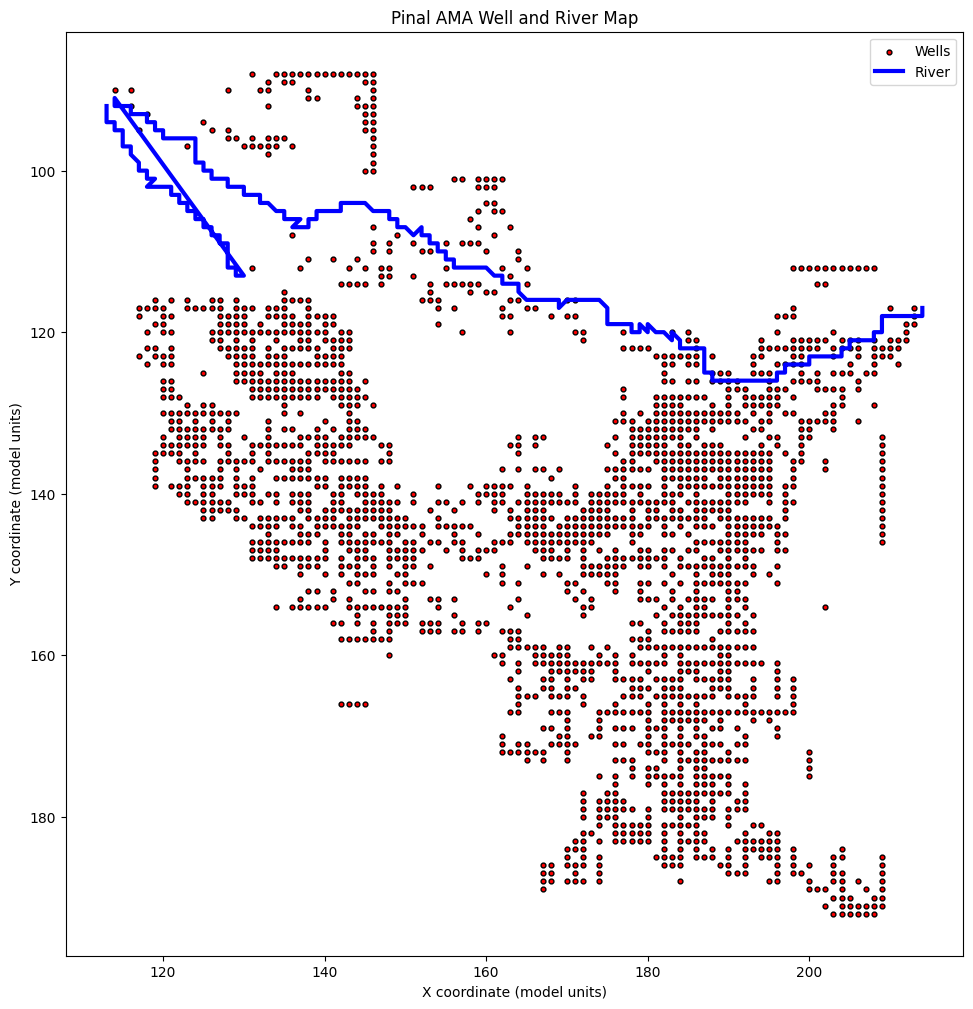

In [ ]:
# Extract well data across all stress periods into a DataFrame
spd_dict = wel.stress_period_data.data  # {kper: recarray}

wells = []
for kper, spd in spd_dict.items():
    # spd is a recarray with fields like 'k', 'i', 'j', 'flux'
    df = pd.DataFrame({
        "k": spd["k"],       # layer index
        "i": spd["i"],       # row index
        "j": spd["j"],       # column index
        "kper": kper,        # stress period
        "flux": spd["flux"]  # pumping rate
    })
    wells.append(df)

wel_df = pd.concat(wells, ignore_index=True)

# Unique wells by i, j
unique_wells_df = wel_df[["i", "j"]].drop_duplicates()
# Calculate mean flux for each well across stress periods
# well_flux = (wel_df.groupby(["i", "j"])["flux"].mean().reset_index())
# Convert flux to positive values for plotting
# well_flux["flux"] = well_flux["flux"].abs()

# Extract river cell locations for plotting
riv_x, riv_y = [], []
str_spd0 = strm.stress_period_data.data[0]
for rec in str_spd0:
    i = rec["i"]
    j = rec["j"]
    riv_y.append(i)
    riv_x.append(j)


# Create plot to visualize wells and river map
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sc = ax.scatter(unique_wells_df["j"], unique_wells_df["i"], s=12, c='r', edgecolors='k', label="Wells")
# sc = ax.scatter(well_flux["j"], well_flux["i"], s=12, c='r', edgecolors='k', label="Wells")
ax.plot(riv_x, riv_y, linewidth=3, c="b", label="River")
# Plot colorbar
# plt.colorbar(sc, label="Mean Pumping Rate (m³/day)")

# Plot the model grid - The grid may be worth learning about for future plotting
# grid.plot(ax=ax, linewidth=0.3, color="gray")

# Set plot labels and title
ax.set_aspect("equal")
ax.set_xlabel("X coordinate (model units)")
ax.set_ylabel("Y coordinate (model units)")
ax.set_title("Pinal AMA Well and River Map")
ax.invert_yaxis()
ax.legend()

plt.show()

In [ ]:
'''
i = row = y-axis (North-South axis: increases downward)
j = col = x-axis (East-West axis: increases rightward)

Target well pairs to turn off
Pair 1: (i=125, j=187), (i=126, j=189)
Pair 2: (i=126, j=202), (i=124, j=200)
Pair 3: (i=127, j=191), (i=128, j=191)

'''
# What version scenario: turn off specific wells
vnum = 1
num_wells = 2       # number of wells to turn off in the scenario (1-6)
target_layer = 0    # example
target_row = 0      # example
target_col = 0      # example
spd_off = None      # None for all stress periods

'''
TODO: Turn contour map into a callable function that can be reused
for original models heads and scenario heads. and a full contour difference map in red/blue
to show where heads increased/decreased between the two model runs.
'''

In [ ]:
def make_scenario_copy(mf_base, scenario_ws):
    mf_scen = deepcopy(mf_base)
    mf_scen.change_model_ws(scenario_ws)
    return mf_scen


# TODO: Update function to turn off a singular or multiple wells
def turn_wells_off(well_spd, layer, row, col, spd=None):
    if spd is None:
        spd_range = well_spd.keys()
    else:
        spd_range = [spd]
    
    for kper in spd_range:
        for rec in well_spd[kper]:
            if (rec['k'] == layer and 
                rec['i'] == row   and 
                rec['j'] == col):
                rec['flux'] = 0.0   # off


# Copy of base model for scenario
mf_well_off = make_scenario_copy(mf, "Wells_off_v{vnum}")
well_off = mf_well_off.wel
well_off_spd = wel.stress_period_data

turn_wells_off(well_off_spd, target_layer, target_row, target_col, spd=spd_off)

# well_off_spd[1] = new_wells
well_off.stress_period_data = well_off_spd
# mf__well_off.write_input()

In [ ]:
def plot_head_contours(mf, head, layer, time):
    pass

k = 1
h2d = head[k, :, :]
htime = times1[-1]
# Mask no-flow or inactive cells
hnoflo = -999.99
h2d_masked = np.ma.masked_where(h2d == hnoflo, h2d)

# Get cell-center coordinates from model grid (2D arrays)
x = mf.modelgrid.xcellcenters
y = mf.modelgrid.ycellcenters

fig, ax = plt.subplots(figsize=(12, 12))

# Choose contour levels (optional)
levels = np.linspace(np.nanmin(h2d_masked), np.nanmax(h2d_masked), 100)

cs = ax.contour(x, y, h2d_masked, levels=levels)
ax.clabel(cs, inline=True, fontsize=8, colors='black')

# Filled contours (optional)
# cf = ax.contourf(x, y, h2d_masked, levels=levels)

ax.set_aspect("equal")
ax.set_xlabel("X (model units)")
ax.set_ylabel("Y (model units)")
ax.set_xlim(250000, 600000)
ax.set_ylim(0, 300000)
ax.set_title(f"Hydraulic Head Contours, layer {k+1}, time={htime}")

plt.show()